<a href="https://colab.research.google.com/github/abir-tcheir/testGit/blob/main/MobilenetV2BIG98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import datetime
from collections import Counter
 
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
 
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
 
from keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam, schedules
 
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

Normal chest x-ray


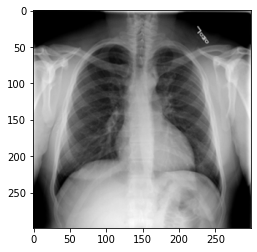

COVID chest x-ray


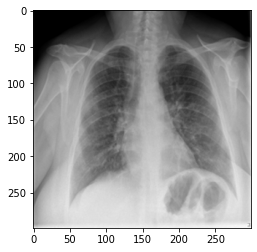

Viral Pneumonia chest x-ray


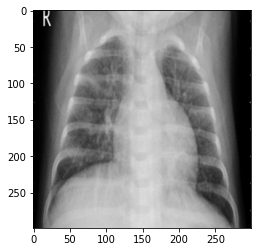

In [ ]:
img_path = '/content/drive/My Drive/Dataset2/'
#img_path = '/content/drive/My Drive/Dataset2/'
#covid_imgs = '/content/COVID-19_Radiography_Dataset/COVID'
#normal_imgs = '/content/COVID-19_Radiography_Dataset/Normal'
#pneumonia_imgs = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia'
 
#covid_imgs = os.listdir(img_path+'/COVID')
#normal_imgs = os.listdir(img_path+'/Non-COVID')
 
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')
 
 
print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("COVID chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()
 
print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

In [ ]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,13678,13678
unique,13678,3
top,COVID/COVID-2451.png,Normal
freq,1,8908


In [ ]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
 # total = len(df.index)
#  freq_r = freq_a[0]/total
 # freq_a[1] = freq_r
  freq_a.columns = ['Label','absolute frequency']
  return freq_a
frequency_plot(df)

,Label,absolute frequency
0,Normal,8908
1,COVID,3425
2,Viral Pneumonia,1345


In [ ]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf
 
#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)
 
 
traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [ ]:
frequency_plot(traindf)

,Label,absolute frequency
0,Normal,6681
1,COVID,2568
2,Viral Pneumonia,1009


In [ ]:
frequency_plot(valdf)

,Label,absolute frequency
0,COVID,429
1,Normal,1113
2,Viral Pneumonia,168


In [ ]:
frequency_plot(testdf)

,Label,absolute frequency
0,COVID,428
1,Normal,1114
2,Viral Pneumonia,168


In [ ]:
BATCH_SIZE = 50
#BATCH_SIZE = 3
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [ ]:
#BATCH_SIZE=50
 
"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
 
print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    #directory="COVID19",
    directory="Dataset2",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    #class_mode="binary",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
 
val_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="Dataset2",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    #batch_size=BATCH_SIZE,
    batch_size=30,
    #class_mode="binary",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)
 
print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="Dataset2",
    x_col="id",
    y_col="label",
    batch_size=5,
    #batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    #class_mode="binary",
    class_mode="categorical",
    
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 10258 validated image filenames belonging to 3 classes.
Found 1710 validated image filenames belonging to 3 classes.

Creating val generator...
Found 1710 validated image filenames belonging to 3 classes.


In [ ]:
#!pip install -U git+https://github.com/qubvel/efficientnet

In [ ]:
#import efficientnet.tfkeras as enet
#base_model =enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights="imagenet",classes=2)
#from keras.applications.resnet import ResNet50
 
#from keras.applications.vgg16 import VGG16
#base_model = VGG16(include_top=False, input_shape=input_shape,
                    # weights='imagenet')

from keras.applications.mobilenet_v2 import MobileNetV2
base_model =MobileNetV2(include_top=False, input_shape=input_shape,
                     weights='imagenet')

#Freeze base convolutional layers
base_model.trainable = False
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
from keras.layers import AveragePooling2D, BatchNormalization
from keras.regularizers import l1_l2
from keras.regularizers import l2
from keras.regularizers import l1
from keras.layers import Dropout
 
model = models.Sequential()
model.add(base_model)
 
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024,activation='relu'))
model.add(layers.Dropout(0.30))
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(3, activation='softmax'))
 
"""
# model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Flatten())
 
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1, activation='sigmoid',name="fc_out"))
 
 
x = base_model.output
 
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
 
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
 
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
# Output layer
predictions = Dense(1, activation="sigmoid")(x)
 
model= Model(inputs = base_model.input, outputs = predictions)
"""
#model.summary()

'\n# model.add(layers.Conv2D(64, 3, activation=\'relu\'))\nmodel.add(layers.Flatten())\n \nmodel.add(layers.Dense(1024, activation=\'relu\'))\nmodel.add(layers.Dropout(0.30))\nmodel.add(layers.Dense(1024, activation=\'relu\'))\nmodel.add(layers.Dropout(0.30))\nmodel.add(layers.Dense(1, activation=\'sigmoid\',name="fc_out"))\n \n \nx = base_model.output\n \nx = BatchNormalization()(x)\nx = Dropout(0.7)(x)\n \nx = Dense(512)(x)\nx = BatchNormalization()(x)\nx = Activation("relu")(x)\nx = Dropout(0.5)(x)\n \nx = Dense(128)(x)\nx = BatchNormalization()(x)\nx = Activation("relu")(x)\n# Output layer\npredictions = Dense(1, activation="sigmoid")(x)\n \nmodel= Model(inputs = base_model.input, outputs = predictions)\n'

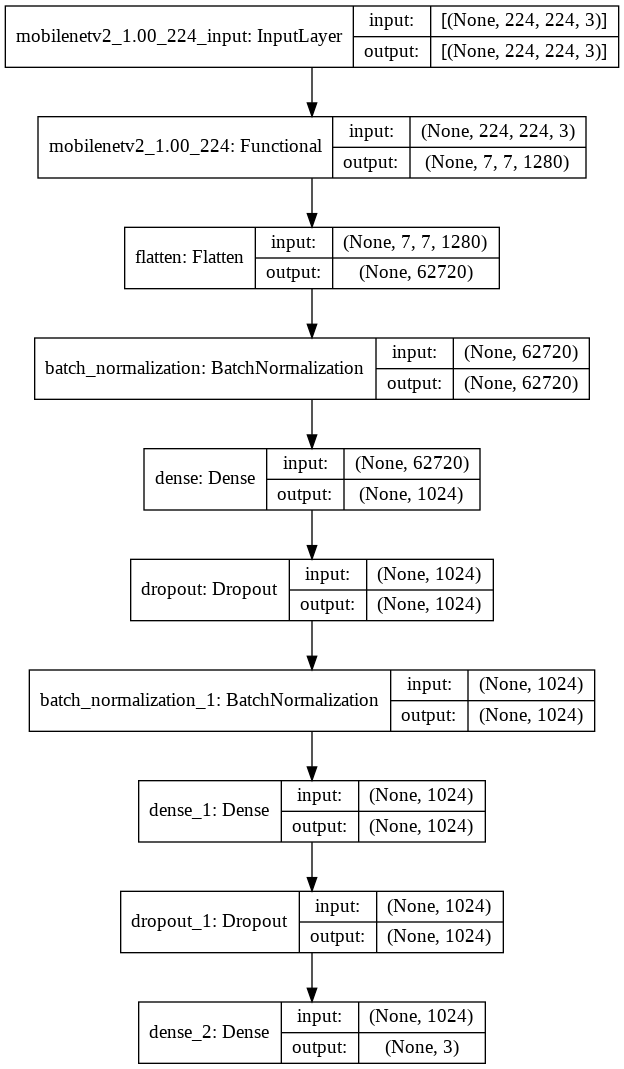

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [16]:
 
 
 #base_convnet.trainable=True 
EPOCHS =21
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
     #loss='binary_crossentropy',
    loss='categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
     metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)
 
#callbacks = [model_checkpoint_callback,early,mcp_save]
history = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    #callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/21
50/50 [==============================] - 736s 15s/step - loss: 0.6437 - recall: 0.6848 - precision: 0.7860 - acc: 0.7340 - val_loss: 0.3916 - val_recall: 0.8440 - val_precision: 0.8755 - val_acc: 0.8600
Epoch 2/21
50/50 [==============================] - 540s 11s/step - loss: 0.3279 - recall: 0.8700 - precision: 0.9093 - acc: 0.8880 - val_loss: 0.2123 - val_recall: 0.9040 - val_precision: 0.9417 - val_acc: 0.9160
Epoch 3/21
50/50 [==============================] - 423s 8s/step - loss: 0.2280 - recall: 0.9184 - precision: 0.9383 - acc: 0.9272 - val_loss: 0.1996 - val_recall: 0.9240 - val_precision: 0.9352 - val_acc: 0.9280
Epoch 4/21
50/50 [==============================] - 327s 6s/step - loss: 0.1694 - recall: 0.9410 - precision: 0.9515 - acc: 0.9467 - val_loss: 0.1715 - val_recall: 0.9320 - val_precision: 0.9395 - val_acc: 0.9360
Epoch 5/21
50/50 [==============================] - 273s 5s/step - loss: 0.1616 - recall: 0.9452 - precision: 0.9540 - acc: 0.9488 - val_loss: 0.1

'\nacc=history.history[\'acc\'], label=\'train data\'\nval_acc=history.history[\'val_acc\']\nloss=history.history[\'loss\']\nval_loss=history.history[\'val_loss\']\n \nplt.plot( acc)\nplt.plot( val_acc)\n#plt.title(\'Training and validation accuracy\')\nplt.title(\'PretrainedResnet50 Train/Test Loss\')\nplt.ylabel(\'Loss\')\nplt.xlabel(\'Number of Epochs\')\nplt.legend(loc="upper left")\n \nplt.figure()\n'

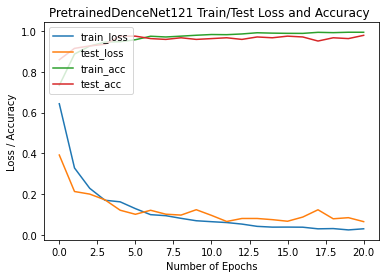

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
 
'''
 
plt.plot(history.history['loss'], label='train data')
plt.plot(history.history['val_loss'], label='test data')
plt.title('PretrainedResnet50 Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.show()
 
# Plot history: Accuracy
plt.plot(history.history['acc'], label='train data')
plt.plot(history.history['val_acc'], label='test data')
plt.title('PretrainedResnet50 Train/Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
plt.show()
'''
N = EPOCHS
#plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="test_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="test_acc")
plt.title("PretrainedDenceNet121 Train/Test Loss and Accuracy ")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss / Accuracy")
plt.legend(loc="upper left")
 
 
'''
acc=history.history['acc'], label='train data'
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
 
plt.plot( acc)
plt.plot( val_acc)
#plt.title('Training and validation accuracy')
plt.title('PretrainedResnet50 Train/Test Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(loc="upper left")
 
plt.figure()
'''

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[ 409   17    2]
 [   9 1100    5]
 [   2    1  165]]
classification_Report
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.96       428
      NORMAL       0.98      0.99      0.99      1114
   PNEUMONIA       0.96      0.98      0.97       168

    accuracy                           0.98      1710
   macro avg       0.97      0.98      0.97      1710
weighted avg       0.98      0.98      0.98      1710



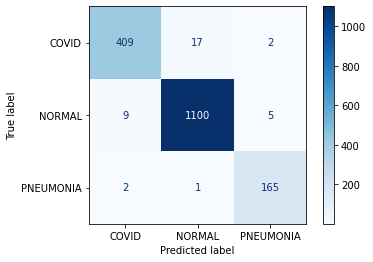

In [20]:
# Confusion Matrix  & Pres  & Recall   & F1-Score
 
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
 
target_names = ['COVID', 'NORMAL', 'PNEUMONIA']
label_names = [0,1,2]
 
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred ,  axis = 1)
 
cm = confusion_matrix(test_generator.classes, y_pred, labels = label_names)
 
 
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
 
print('classification_Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))
 
disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues, values_format = 'g')
plt.show()